In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import datetime
from collections import Counter
import models
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Connect to airbnb database
connection = sqlite3.connect('D:\JHU\Data Science\Term project/airbnb.db')

In [3]:
# Query the listings table in airbnb.db and convert the listings table to dataframe
vwListings = pd.read_sql('SELECT * FROM most_recent_listings', connection)

Since the original data set contains a lot of noise, we will clean it up before feeding to the model. After completing EDA, we decided to drop some observations, convert data types, and manipulate some variables.

In [4]:
## convert price to numeric
vwListings['price'] = vwListings['price'].str.replace(',','',regex=False)
vwListings['price'] = vwListings['price'].str.strip('$').astype('float')

In [5]:
## STEVE: host_reponse_rate, host_acceptance_rate - fillna ('') with 0
# Create room_type_mod grouping hotel rooms together
vwListings['room_type_mod'] = vwListings['room_type']
vwListings.loc[vwListings['property_type'].isin(['Room in hotel', 'Room in boutique hotel',
        'Private room in bed and breakfast']), 'room_type_mod'] = 'Hotel room'

# Drop the listings having price = 0
vwListings.drop(vwListings.loc[vwListings['price']==0].index, inplace=True)

# Drop the unavailable listings
vwListings.drop(vwListings.loc[vwListings['has_availability']=='f'].index, inplace=True)
vwListings = vwListings.reset_index(drop=True)

# Replace null reviews_per_month = 0
vwListings['reviews_per_month'] = vwListings['reviews_per_month'].replace({'': 0})

# Drop 2 listings having over 31 reviews per month
vwListings.drop(vwListings.loc[vwListings['reviews_per_month'] > 31].index, inplace=True)
vwListings = vwListings.reset_index(drop=True)

# Replace null year in host_since by the most common value 2019-09-13
vwListings['host_since'] = vwListings['host_since'].replace({'': '2019-09-13'})
vwListings['host_since'] = pd.to_datetime(vwListings['host_since'])

# Replace null value by 'N/A' in host_response_time
vwListings['host_response_time'] = vwListings['host_response_time'].replace({'': 'N/A'})

# Replace N/A value in host_response_rate = 0
vwListings['host_response_rate'] = vwListings['host_response_rate'].str.replace('N/A', '0%')
vwListings['host_response_rate'] = vwListings['host_response_rate'].str.replace('%', '')
vwListings['host_response_rate'] = pd.to_numeric(vwListings['host_response_rate'])
vwListings['host_response_rate'] = vwListings['host_response_rate'].fillna(0)

# Replace N/A value in host_acceptance_rate = 0
vwListings['host_acceptance_rate'] = vwListings['host_acceptance_rate'].str.replace('N/A', '0%')
vwListings['host_acceptance_rate'] = vwListings['host_acceptance_rate'].str.replace('%', '')
vwListings['host_acceptance_rate'] = pd.to_numeric(vwListings['host_acceptance_rate'])
vwListings['host_acceptance_rate'] = vwListings['host_acceptance_rate'].fillna(0)

# Replace null value by 'f' in host_is_superhost
vwListings['host_is_superhost'] = vwListings['host_is_superhost'].replace({'': 'f'})

# Replace null value by 'f' in host_verifications
vwListings['host_verifications'] = vwListings['host_verifications'].replace({'': 'f'})

# Replace null value by 'f' in host_has_profile_pic
vwListings['host_has_profile_pic'] = vwListings['host_has_profile_pic'].replace({'': 'f'})

# Replace null value by 'f' in host_identity_verified
vwListings['host_identity_verified'] = vwListings['host_identity_verified'].replace({'': 'f'})

Next, we will clean the bedrooms variable. We will follow the rules below:
- If the value of the bedrooms variable is null and the value of the beds variable is not null, bedrooms will be equal to the value of beds.
- If the value of the beds variable is null and the value of the bedrooms variable is not null, beds will be equal to the value of bedrooms.
- Otherwise, both of the variables will be equal the mean of corresponding variable.

In [6]:
vwListings.loc[(vwListings['bedrooms'] == '')&(vwListings['beds'] == ''), ['bedrooms', 'beds']] = [2, 2]
vwListings.loc[vwListings['bedrooms'] == '', 'bedrooms'] = vwListings.loc[vwListings['bedrooms'] == '', 'beds']
vwListings.loc[vwListings['beds'] == '', 'beds'] = vwListings.loc[vwListings['beds'] == '', 'bedrooms']

vwListings['bedrooms'] = pd.to_numeric(vwListings['bedrooms'])
vwListings['beds'] = pd.to_numeric(vwListings['beds'])

We will convert some bathroom text to the number of bathrooms based on the human's interpretation. With the null values or the half bathroom only, we will assume the number of bathrooms is equal to the mean bathrooms which is 1.

In [7]:
vwListings.loc[vwListings['bathrooms_text'] == '0 shared baths', 'bathrooms_text'] = \
    vwListings.loc[vwListings['bathrooms_text'] == '0 shared baths', 'bedrooms'].astype('str') + ' baths'
vwListings['bathrooms_text'] = vwListings['bathrooms_text'].replace(
    ['0 baths', 'Half-bath', 'Private half-bath', 'Shared half-bath', ''], '1 bathroom')

In [8]:
# Extract the number of bathrooms from bathroom_text.
vwListings['bathroom_numbers'] = vwListings['bathrooms_text'].str.split().str.get(0)
vwListings['bathroom_numbers'] = pd.to_numeric(vwListings['bathroom_numbers'])

In [9]:
# This step is to prepare for One Hot Encodings
for i in range(len(vwListings['host_response_time'])):
    if 'within an hour' in vwListings['host_response_time'][i]:
        vwListings['host_response_time'][i] = 'within_an_hour'
    elif 'N/A' in vwListings['host_response_time'][i]:
        vwListings['host_response_time'][i] = 'na'
    elif 'within a few hours' in vwListings['host_response_time'][i]:
        vwListings['host_response_time'][i] = 'within_a_few_hours'
    elif 'within a day' in vwListings['host_response_time'][i]:
        vwListings['host_response_time'][i] = 'within_a_day'
    elif 'a few days or more' in vwListings['host_response_time'][i]:
        vwListings['host_response_time'][i] = 'a_few_days_or_more'

        
for i in range(len(vwListings['room_type_mod'])):
    if 'Entire home/apt' in vwListings['room_type_mod'][i]:
        vwListings['room_type_mod'][i] = 'entire_home_apt'
    elif 'Private room' in vwListings['room_type_mod'][i]:
        vwListings['room_type_mod'][i] = 'private_room'
    elif 'Hotel room' in vwListings['room_type_mod'][i]:
        vwListings['room_type_mod'][i] = 'hotel_room'
    elif 'Shared room' in vwListings['room_type_mod'][i]:
        vwListings['room_type_mod'][i] = 'shared_room'

In [10]:
# Convert the all the review scores to numeric
vwListings['review_scores_rating'] = pd.to_numeric(vwListings['review_scores_rating'])
vwListings['review_scores_accuracy'] = pd.to_numeric(vwListings['review_scores_accuracy'])
vwListings['review_scores_cleanliness'] = pd.to_numeric(vwListings['review_scores_cleanliness'])
vwListings['review_scores_checkin'] = pd.to_numeric(vwListings['review_scores_checkin'])
vwListings['review_scores_communication'] = pd.to_numeric(vwListings['review_scores_communication'])
vwListings['review_scores_location'] = pd.to_numeric(vwListings['review_scores_location'])
vwListings['review_scores_value'] = pd.to_numeric(vwListings['review_scores_value'])

In [11]:
## STEVE: fill review_scores na with the mean
for col in vwListings.columns:
    if col.startswith('review_scores'):
        x = vwListings[col]
        vwListings[col] = vwListings[col].fillna(x.mean())

In [12]:
#  the coordinates (latitude, longtitute of a place from google map )
smithsonian_lat = 38.8889532077163
smithsonian_long = -77.0259992316524
lincoln_memorial_lat = 38.8893771334115
lincoln_memorial_long = -77.0501761044084
capitol_lat = 38.8900557831996
capttol_long = -77.0090290467363
white_house_lat = 38.9103145107623
white_house_long = -77.0221504467353
library_of_congress_lat = 38.8888008852652
library_of_congress_long = -77.0047082755724
nationals_park_lat = 38.8731981381059
nationals_park_long = -77.0074329
national_zoo_lat = 38.9294590679026
national_zoo_long = -77.0492384835061
union_station_lat = 38.8973065709087
union_station_long = -77.00629767372
mcpherson_sq_lat = 38.9028682064423
mcpherson_sq_long = -77.0324745881233

In [13]:
# distance unit = miles
vwListings["distance_smithsonian"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(smithsonian_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(smithsonian_lat))
                                            *np.cos(np.radians(smithsonian_long-vwListings["longitude"])) )*3963*1.15077945

In [14]:
vwListings["distance_lincoln"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(lincoln_memorial_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(lincoln_memorial_lat))
                                            *np.cos(np.radians(lincoln_memorial_long-vwListings["longitude"])) )*3963*1.15077945

In [15]:
vwListings["distance_capitol"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(capitol_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(capitol_lat))
                                            *np.cos(np.radians(capttol_long-vwListings["longitude"])) )*3963*1.15077945

In [16]:
vwListings["distance_white_house"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(white_house_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(white_house_lat))
                                            *np.cos(np.radians(white_house_long-vwListings["longitude"])) )*3963*1.15077945

In [17]:
vwListings["distance_library_congress"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(library_of_congress_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(library_of_congress_lat))
                                            *np.cos(np.radians(library_of_congress_long-vwListings["longitude"])))*3963*1.15077945

In [18]:
vwListings["distance_nationals_park"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(nationals_park_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(nationals_park_lat))
                                            *np.cos(np.radians(nationals_park_long-vwListings["longitude"])) )*3963*1.15077945

In [19]:
vwListings["distance_national_zoo"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(national_zoo_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(national_zoo_lat))
                                            *np.cos(np.radians(national_zoo_long-vwListings["longitude"])) )*3963*1.15077945

In [20]:
vwListings["distance_railway"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(union_station_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(union_station_lat))
                                            *np.cos(np.radians(union_station_long-vwListings["longitude"])) )*3963*1.15077945

In [21]:
vwListings["distance_mcpherson"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(mcpherson_sq_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(mcpherson_sq_lat))
                                            *np.cos(np.radians(mcpherson_sq_long-vwListings["longitude"])) )*3963*1.15077945

We will convert one hot encodings for the following categorical variables host_response_time, host_is_superhost, host_has_profile_pic, host_identity_verified, room_type_mod

In [22]:
vwListings = pd.concat([vwListings, pd.get_dummies(vwListings['host_response_time'], prefix='response_time', prefix_sep='_')], axis=1)
vwListings = pd.concat([vwListings, pd.get_dummies(vwListings['host_is_superhost'], prefix='superhost', prefix_sep='_')], axis=1)
vwListings = pd.concat([vwListings, pd.get_dummies(vwListings['host_identity_verified'], prefix='identity_verified', prefix_sep='_')], axis=1)
vwListings = pd.concat([vwListings, pd.get_dummies(vwListings['host_has_profile_pic'], prefix='profile', prefix_sep='_')], axis=1)
vwListings = pd.concat([vwListings, pd.get_dummies(vwListings['room_type_mod'])], axis=1)
vwListings = pd.concat([vwListings, pd.get_dummies(vwListings['instant_bookable'], prefix='instant_bookable', prefix_sep='_')], axis=1) # ADDED

In [23]:
vwListings.loc[(vwListings['host_id']==294545484)&(vwListings['room_type_mod']=='private_room'), 'bedrooms'] = 1
vwListings.loc[vwListings['maximum_nights'] < vwListings['minimum_nights'], 'maximum_nights'] = vwListings.loc[
    vwListings['maximum_nights'] < vwListings['minimum_nights'], 'minimum_nights']

In [24]:
vwListings.loc[vwListings['maximum_nights'] > 1125, 'maximum_nights'] = 1125

In [25]:
base_date = pd.Timestamp('2023-03-19')

In [26]:
vwListings['last_review'] = pd.to_datetime(vwListings['last_review'])
vwListings['days_since_last_review'] = vwListings['last_review'].apply(lambda x: (base_date - x).days)
vwListings.loc[vwListings['days_since_last_review'].isna(), 'days_since_last_review'] =\
    vwListings['days_since_last_review'].mean()

In [27]:
vwListings['days_since_host_joined'] = vwListings['host_since'].apply(lambda x: (base_date - x).days)

## Regression Model

Our initial model contains 39 features. We outline our expectations for their coefficients below (note that some features have been grouped together).

<ol>
    <li><b>response_time_a_few_days_or_more:</b> negative. A host with a bad history of responding probably has to charge a bit less to attract guests.</li>
    <li><b>response_time_within_a_day:</b> negative. Within a day is still a long time compared to the other.</li>
    <li><b>response_time_within_a_few_hours:</b> positive.</li>
    <li><b>response_time_within_an_hour:</b> positive. Convsersely, hosts with good histories of responding can probably charge a bit more because they provide better service to potential guests.</li>
    <li><b>host_response_rate:</b> positive. A more-responsive host probably attracts more guests, allowing them to charge more.</li>
    <li><b>host_acceptance_rate:</b> positive. Guests are more likely to be attracted to a listing they think they're likely to be able to book.</li>
    <li><b>superhost_t:</b> positive. Being a superhost is evidence of consistent good service.</li>
    <li><b>profile_t:</b> positive.</li>
    <li><b>identity_verified_t:</b> positive. Having a profile picture and verified identity is likely to build trust with prospective guests.</li>
    <li><b>entire_home_apt, hotel_room, private_room:</b> positive. Each of these room_types are being compared to the shared room baseline, which should be cheaper than all of them.</li>
    <li><b>accommodates, bathroom_numbers, bedroom, beds:</b> positive. As each of these increases, more people can stay comfortably at a listing. A higher price can be divided among more people.</li>
    <li><b>minimum_nights, maximum_nights:</b> negative. Listings with higher numbers of nights are medium- or long-term rentals, and those can't command the prices that many short-term rentals can.</li>
    <li><b>number_of_reviews:</b> positive. More reviews mean a more reliable record of the listing's quality.</li>
    <li><b>review_scores:</b> all positive. Guests are willing to pay more for listings with a better track record.</li>
    <li><b>instant_bookable_t:</b> positive. There might be a small premium for listings that allow instant bookings.</li>
    <li><b>calculated_host_listings_count:</b> negative. Hosts with more listings might not provide the same personalized service. They also might be more likely to list medium- or long-term rentals.</li>
    <li><b>distances:</b> all negative. Most of the landmarks in our secondary dataset are fairly close to the city center, so price should generally decrease as a listing gets further away from them. We expect some to be redundant.</li>
    <li><b>days_since_last_review:</b> negative. More recent reviews means a listing has more reliable information available.</li>
    <li><b>days_since_host_joined:</b> positive. The more experienced the host, the better.</li>
<ol>

## Model 1

We use the bootstrap method to estimate the coefficients of the initial "all-in" model.

In [28]:
np.random.seed(1453496)
model1 = ("price ~ response_time_a_few_days_or_more + response_time_within_a_day "
        "+ response_time_within_a_few_hours + response_time_within_an_hour + host_response_rate "
        "+ host_acceptance_rate + superhost_t "
        "+ profile_t + identity_verified_t + entire_home_apt + hotel_room + private_room + accommodates "
        "+ bathroom_numbers + bedrooms + beds + minimum_nights + maximum_nights + number_of_reviews "
        "+ review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin "
        "+ review_scores_communication + review_scores_location + review_scores_value + instant_bookable_t "
        "+ calculated_host_listings_count + distance_smithsonian + distance_lincoln + distance_capitol "
        "+ distance_white_house + distance_library_congress + distance_nationals_park + distance_national_zoo "
        "+ distance_railway + distance_mcpherson + days_since_last_review + days_since_host_joined")
result1 = models.bootstrap_linear_regression(model1, data=vwListings)
models.describe_bootstrap_lr(result1, sd=4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-232.5623,-316.5111,-172.3527
response_time_a_few_days_or_more,$\beta_{1}$,-4.9648,-39.4306,35.1272
response_time_within_a_day,$\beta_{2}$,-12.9884,-70.7150,80.2422
response_time_within_a_few_hours,$\beta_{3}$,-40.4081,-87.5234,42.6008
response_time_within_an_hour,$\beta_{4}$,-8.2019,-60.3764,82.1980
host_response_rate,$\beta_{5}$,-0.0367,-0.9417,0.5423
host_acceptance_rate,$\beta_{6}$,0.2788,0.0092,0.5600
superhost_t,$\beta_{7}$,10.5352,0.6903,22.2581
profile_t,$\beta_{8}$,3.3246,-18.7033,25.5040


In [29]:
len(result1["residuals"])

8161

The $R^2$ is 0.346, with a standard error of 166.59. The mean price is 178.81, so the error isn't great compared to the scale of the data. However, it is a marked improvement over the standard error of the null model, which is 205.54.

Comparing the bootstrap coefficients to our prior beliefs shows some clear candidates to be dropped from the model:
<ul>
    <li><b>response_time_within_a_few_hours:</b> expected positive, estimated weak negative</li>
    <li><b>response_time_within_an_hour:</b> expected positive, estimated weak negative</li>
    <li><b>host_response_rate:</b> expected positive, estimated weak negative</li>
    <li><b>identity_verified_t:</b> expected positive, estimated weak negative</li>
    <li><b>review_scores_checkin, review_scores_communication:</b> expected positive, estimated weak negative</li>
    <li><b>distance_lincoln:</b> expected negative, estimated weak positive</li>
    <li><b>days_since_host_joined:</b> expected positive, estimated weak negative</li>
</ul>

We will drop those features and keep an eye on some others. review_scores_value was expected to have a positive coefficient, but its estimated coefficient is negative and barely includes zero in its 95% confidence interval. A negative coefficient does also make sense, though. distance_smithsonian was expected negative but its estimated coefficient is positive and includes zero in its 95% confidence interval. Zero is towards the end of the range, however, so we keep it in for now.

### Model 2

We use the bootstrap method to estimate the new, trimmed-down model.

In [30]:
np.random.seed(1457896)
model2 = ("price ~ response_time_a_few_days_or_more + response_time_within_a_day "
        "+ host_acceptance_rate + superhost_t "
        "+ profile_t + entire_home_apt + hotel_room + private_room + accommodates "
        "+ bathroom_numbers + bedrooms + beds + minimum_nights + maximum_nights + number_of_reviews "
        "+ review_scores_rating + review_scores_accuracy + review_scores_cleanliness "
        "+ review_scores_location + review_scores_value + instant_bookable_t "
        "+ calculated_host_listings_count + distance_smithsonian + distance_capitol "
        "+ distance_white_house + distance_library_congress + distance_nationals_park + distance_national_zoo "
        "+ distance_railway + distance_mcpherson + days_since_last_review")
result2 = models.bootstrap_linear_regression(model2, data=vwListings)
models.describe_bootstrap_lr(result2, sd=4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-290.3472,-376.0987,-221.8026
response_time_a_few_days_or_more,$\beta_{1}$,8.4557,-26.4725,41.4873
response_time_within_a_day,$\beta_{2}$,-0.0052,-17.7019,24.6040
host_acceptance_rate,$\beta_{3}$,0.2410,-0.0509,0.5140
superhost_t,$\beta_{4}$,10.0362,1.0641,21.6564
profile_t,$\beta_{5}$,-1.7201,-29.0018,26.2517
entire_home_apt,$\beta_{6}$,68.1921,46.1110,99.3625
hotel_room,$\beta_{7}$,179.7294,149.9088,211.8742
private_room,$\beta_{8}$,38.9381,19.5618,66.0031


After removing eight features, the $R^2$ of the new model is 0.343. This is only lower than the old $R^2$ by 0.003. The standard error is 166.95, only slightly higher than the old standard error of 166.59. The increased simplicity of the new model is worth these small tradeoffs.

Comparing the bootstrap coefficients to our prior beliefs shows a couple more clear candidates to be dropped from the model:
<ul>
    <li><b>response_time_a_few_days_or_more:</b> expected negative, estimated weak positive</li>
    <li><b>profile_t:</b> expected positive, estimated weak negative</li>
</ul>

review_scores_value and distance_smithsonian still have the opposite sign of the initial prediction. The confidence interval for distance_smithsonian no longer includes zero, and the confidence interval for review_scores_value still barely includes zero, so we keep both in the model.

### Model 3

We use the bootstrap method to estimate the third model.

In [31]:
np.random.seed(1432896)
model3 = ("price ~ response_time_within_a_day "
        "+ host_acceptance_rate + superhost_t "
        "+ entire_home_apt + hotel_room + private_room + accommodates "
        "+ bathroom_numbers + bedrooms + beds + minimum_nights + maximum_nights + number_of_reviews "
        "+ review_scores_rating + review_scores_accuracy + review_scores_cleanliness "
        "+ review_scores_location + review_scores_value + instant_bookable_t "
        "+ calculated_host_listings_count + distance_smithsonian + distance_capitol "
        "+ distance_white_house + distance_library_congress + distance_nationals_park + distance_national_zoo "
        "+ distance_railway + distance_mcpherson + days_since_last_review")
result3 = models.bootstrap_linear_regression(model3, data=vwListings)
models.describe_bootstrap_lr(result3, sd=4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-290.9995,-382.2209,-214.5899
response_time_within_a_day,$\beta_{1}$,-0.1986,-19.3994,23.6507
host_acceptance_rate,$\beta_{2}$,0.2378,-0.0839,0.5777
superhost_t,$\beta_{3}$,9.9441,0.1071,18.4711
entire_home_apt,$\beta_{4}$,68.3110,45.9902,107.3268
hotel_room,$\beta_{5}$,179.9870,147.8385,223.6419
private_room,$\beta_{6}$,39.0506,21.1274,66.1441
accommodates,$\beta_{7}$,12.7088,-4.7417,24.4314
bathroom_numbers,$\beta_{8}$,35.5862,20.8528,59.4055


After removing two more features, the $R^2$ of the new model is 0.343, within a rounding error of the old $R^2$. The standard error is 166.93, again nearly the same as Model 2.

In [38]:
def plot_residuals(result, variables):
    figure = plt.figure(figsize=(20,6))

    variables = ["hotel_room", "distance_capitol", "distance_mcpherson", "distance_library_congress"]

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(vwListings[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

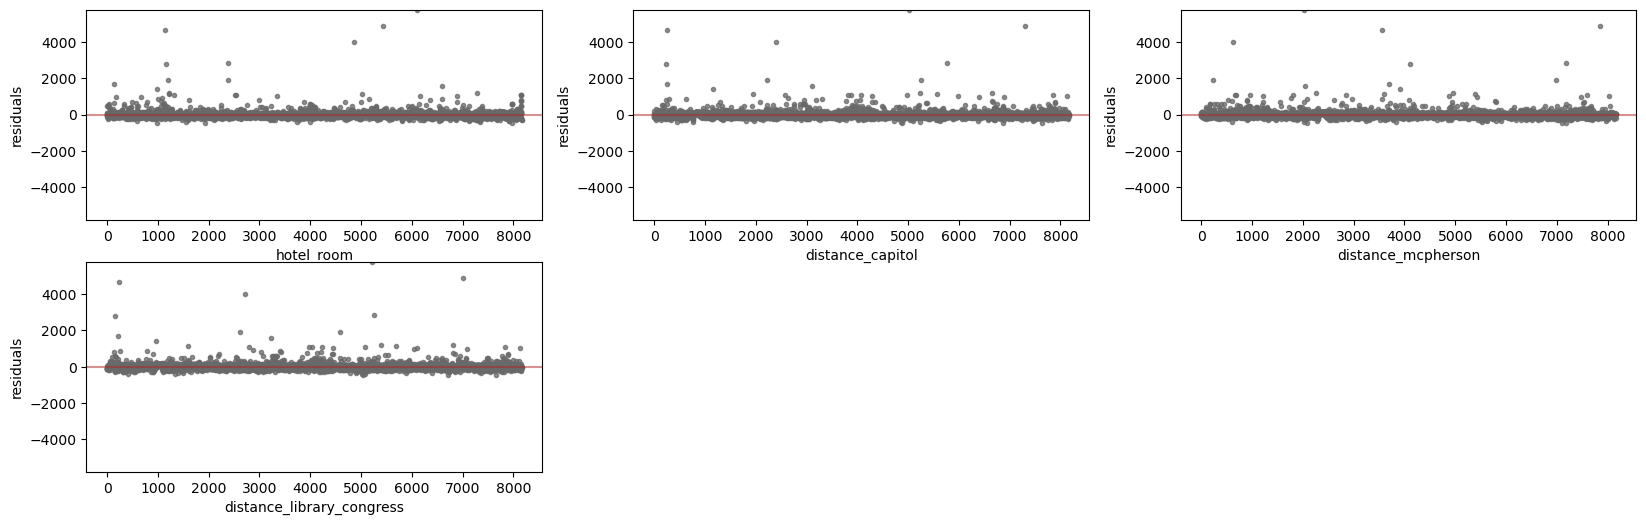

In [39]:
residuals1 = plot_residuals(result1, ["hotel_room", "distance_capitol", "distance_mcpherson","distance_library_congress"])

In [58]:
model4 = ("price ~ response_time_within_a_day "
        "+ host_acceptance_rate + superhost_t "
        "+ entire_home_apt + hotel_room + private_room + accommodates "
        "+ bathroom_numbers + bedrooms + beds + minimum_nights + maximum_nights + number_of_reviews "
        "+ review_scores_rating + review_scores_accuracy + review_scores_cleanliness "
        "+ review_scores_location + review_scores_value + instant_bookable_t "
        "+ calculated_host_listings_count + latitude + longitude")
result4 = models.bootstrap_linear_regression(model4, data=vwListings)
models.describe_bootstrap_lr(result4, sd=4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-27091.2029,-37541.4220,-12327.3051
response_time_within_a_day,$\beta_{1}$,-10.2692,-27.3072,5.2236
host_acceptance_rate,$\beta_{2}$,0.0824,-0.1490,0.2180
superhost_t,$\beta_{3}$,7.5970,-1.2642,16.1835
entire_home_apt,$\beta_{4}$,78.5033,45.8257,110.3726
hotel_room,$\beta_{5}$,222.6358,176.3738,257.9775
private_room,$\beta_{6}$,36.1901,14.1950,59.3671
accommodates,$\beta_{7}$,12.1364,-2.8362,26.1622
bathroom_numbers,$\beta_{8}$,34.7600,19.1433,52.4262
